In [1]:
%load_ext Cython

In [2]:
%%cython
import numpy as np
import pandas as pd
#dictionary型に変換する関数
def two_list_to_dict(key_list, val_list):
      return dict(zip(key_list, val_list))

#csvを読み込んで行ごとに分割
def read_file(filename):
    with open(str(filename),'r',encoding='utf8') as fbrand:
        txt=fbrand.read() 
        lines = txt.split("\n")
        return lines

#csvの各行を分割してコーデごとのブランドlistのlistを作る.
def make_Coordinate(lines):
    Coordinate=[]
    #重複のない辞書にするためにsetを用いる
    s=set()
    for line in lines:
        brands=line.split(",")
        Coordinate.append(brands)
    return Coordinate

#good_tagsのみに絞る
def make_goodtags(lines,good_tags_set):
    good_tags_list=[]
    #重複のない辞書にするためにsetを用いる
    s=set()
    s=good_tags_set
    for line in lines:
        tags=line.split(",")
        good_tags=[t for t in tags if t in s] 
        #if len(good_tags) == 0:
        good_tags_list.append(good_tags)
    return good_tags_list

def make_brandset(lines):
    #重複のない辞書にするためにsetを用いる
        s=set()
        for line in lines:
            brands=line.split(",")
            for brand in brands:
                s.add(brand)
        brand_set=list(s)
        print(len(brand_set))
        return brand_set

def make_dict(brandset):
    #dictionaryのindex
    index=[]
    for i in range(len(brandset)):
        index.append(i)
    #辞書
    brand_dict=two_list_to_dict(brandset,index)
    return brand_dict

def brand_to_dictnum(Coordinates,brand_dict):
    W = [] # words
    #ブランドと補助情報の文書ごとのリストを作る
    for Coordinate in Coordinates:
    #list()をつけない場合iterator objectが帰ってくる
        W.append(list(map(lambda v:brand_dict[v],Coordinate)))
    return W


#結果に関する関数
#コーディネートとトピック番号を紐づける．
def brand_to_topic(Coordinates,nctm_Z): #nctm.Zはnctm.fitの結果が入っている
    brand_topic=[]
    for brands, Topics in zip(Coordinates,nctm_Z):
        for brand,Topic in zip(brands,Topics):
            pair=[brand,Topic]
            brand_topic.append(pair)
    return brand_topic

#各topicごとのリストにまとめる．
def brand_topic_list_f(brand_topic,K):
    brand_topic_list=[]
    for i in range(K):
        aaa=[x for x in brand_topic if x[1] == i]
        brand_topic_list.append(aaa)
    return brand_topic_list

#tagについては少し異なる扱い(ノイズ判定)
#各トピックごとにノイズ判定をする必要がある．
def tag_to_topic(Tags_list,nctm_Y,nctm_R): #nctm.Zはnctm.fitの結果が入っている
    tag_topic=[]
    for Tags,Topics,Noises in zip(Tags_list,nctm_Y,nctm_R):
        for tag,topic,noise in zip(Tags,Topics,Noises):
            pair=[tag,topic,noise] #3番目の要素としてノイズかどうかの値も入れる．
            tag_topic.append(pair)
    return tag_topic

#topicごとにnoiseリストとtagリストを作る
def tag_topic_list_f(tag_topic,K):
    tag_topic_list=[]
    noisetag_topic_list=[]
    #K個のtopicについて
    for i in range(K): 
        #x[1](トピック番号==i)ならばi番目のトピックから生成したタグとする．
        #そのときx[2](ノイズ判定==0)ならばi番目のトピックにおけるノイズとする．
        not_noise=[x for x in tag_topic if x[1] == i and x[2] == 1]
        noise=[x for x in tag_topic if x[1] == i and x[2] == 0] 
        tag_topic_list.append(not_noise)
        noisetag_topic_list.append(noise)
    return tag_topic_list,noisetag_topic_list

#各トピックごとにsetを作る．
def t_setlist_brand_f(brand_topic_list,K):
    t_setlist_brand=[] #各トピックごとのbrandのsetを代入するリスト
    for i in range(K): #各トピックで回す
        a=[] #各トピックでsetを作るためのローカル変数
        for item in brand_topic_list[i]:
            a.append(item[0])
        a=set(a) #セットにする
        a=list(a) #リストに直す
        t_setlist_brand.append(a) #現在のトピックのsetをグローバルのリストに追加
    return t_setlist_brand

#各トピックごとの語彙の出現回数
def count_topic_f(brand_topic_list,t_setlist_brand,K):
    count_topic=[] #全トピックの出現回数リストのリスト
    for i in range(K): #トピックループ
        count=np.zeros((len(t_setlist_brand[i]))) #今見ているトピックのsetの長さ分のbrandカウント配列を初期化
        for item in brand_topic_list[i]: #itemはリスト
            count[t_setlist_brand[i].index(item[0])]+=1 #今見ているbrandのインデックスをカウントアップ
        count_topic.append(count) #一つのトピックについて見終えたらグローバルに追加
    return count_topic

def count_noise(tag_set,R):
    count=np.zeros(len(tag_set)) #今見ているトピックのsetの長さ分のbrandカウント配列を初期化
    for item in R: #itemはリスト
        count[item]+=1 #今見ているbrandのインデックスをカウントアップ
    return count

def write_result(path,filename,t_setlist_brand,count_topic):
    topic_num=0
    for item,count in zip(t_setlist_brand,count_topic):
        tuples=[]
        for b,c in zip(item,count):
            tuples.append(tuple((b,c)))
        tuples.sort(key=lambda x:x[1],reverse=True) #x[1]に出現回数が入っているので多い順にソート
        df=pd.DataFrame(tuples)
        if topic_num < 10:
            df.to_csv(str(path)+'topic'+'0'+str(topic_num)+str(filename), index=False )
        else:
            df.to_csv(str(path)+'topic'+str(topic_num)+str(filename), index=False )
        topic_num+=1
    print("END")
    
def output(path,filename,nctmR):
    import csv
    with open(str(path)+str(filename),'w') as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerows(nctmR)
        
def output_Perp(path,filename,Perp):
    import csv
    with open(str(path)+str(filename),'w') as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerow(Perp)
        
def save_img(img_path,iteration,K,nctmperplexity):
    import matplotlib.pyplot as plt
    x=np.linspace(1,iteration,iteration)
    print(len(x))
    y=np.array(nctmperplexity)
    print(len(y))
    plt.plot(x,y,'-r')
    plt.savefig(str(img_path)+str(K))
    

In [3]:
good_tag_lines=read_file('./cleansing_data/goodtags10000.csv')
#good_tag_input=make_Coordinate(good_tag_lines)
good_tag_input=make_Coordinate(good_tag_lines)
Coordinate_lines=read_file('./cleansing_data/goodCoords10000.csv')
# good_Coordinate_input=make_Coordinate(Coordinate_lines)
good_Coordinate_input=make_Coordinate(Coordinate_lines)

In [4]:
# import csv #書き込み時にコメントアウト外す
# with open('./cleansing_data/goodCoords10000.csv','w') as fC:
#     writer = csv.writer(fC, lineterminator='\n')
#     writer.writerows(good_Coordinate_input)
# with open('./cleansing_data/goodtags10000.csv','w') as ft:
#     writer = csv.writer(ft, lineterminator='\n')
#     writer.writerows(good_tag_input)

In [5]:
# モデルに入れる前に形式を合わせる必要がある
tag_set=make_brandset(good_tag_lines)
# tag_set=make_brandset(good_tag_lines)
tag_dict=make_dict(tag_set)
brand_set=make_brandset(Coordinate_lines)
# brand_set=make_brandset(Coordinate_lines)
brand_dict=make_dict(brand_set)
tag_W=brand_to_dictnum(good_tag_input,tag_dict)
Coordinate_W=brand_to_dictnum(good_Coordinate_input,brand_dict)

3219
3298


In [6]:
print(good_tag_input[0:10])
print(tag_W[0:10])

[["who's who chico", 'シンプル', 'フレアスカート', 'ニットスカート'], ['シンプル', 'スニーカー', 'タートルネックニット', 'ロシアン帽', '青文字系', 'ニコアンド', 'コンバース', '冬'], ['WEGO', '出勤コーデ', 'ヘアバンド', 'お団子ヘアー', 'レーストップス', 'カーディガン', 'リボン', 'コンバース', 'GU'], ['冬', 'ワンピース', '白ニット', 'ダッフルコート', 'ミニスカート', 'ヘアバンド'], ['結婚式', 'パーティースタイル', 'オケージョン', 'オールインワン', 'サロペット', 'ダウンジャケット', 'ネックレス', 'きれいめカジュアル'], ['きれいめカジュアル', 'カジュアル', 'ホワイト', 'ベージュ', 'カットオフ', 'キャップ', 'ストリート', 'スウェット', 'ローキャップ', 'ラフ'], ['アウター', 'ピンク', 'ノーカラーコート', 'シャギー', 'ワイドスリーブ', 'コーデュロイ', 'ニット'], ['ダメージデニムパンツ', 'レオパード', 'ショートブーツ', 'Doシンプル部', 'いい友連合', 'ロングカーディガン', 'オトナカジュアル', 'きれいめカジュアル', 'お団子ヘアー', 'ダメージデニム'], ['ミリタリー', 'ミリタリージャケット', 'フライトジャケット', '黒スキニー', 'ユニクロ', 'ドレスシューズ', '白ソックス', '冬'], ['シンプル', 'ダル着', 'チャンピオン', 'AVIREX', 'ディッキーズ(Dickies)', 'ちょっとそこまで']]
[[1465, 818, 206, 282], [818, 24, 3037, 3209, 1587, 316, 2392, 2620], [2605, 2637, 937, 952, 1634, 428, 1331, 2392, 2704], [2620, 3133, 1446, 991, 2553, 937], [161, 2567, 318, 2339, 3048, 2784, 3103, 1842], [1842, 112, 1876, 3016, 726,

## ハイパーパラメータをいじるのがよさそう
どうやらRがほとんど0に収束してしまうのはこれが原因ぽい

In [7]:
#リスタートしないとグラフの線が増える．
from nctm_perplexity import NCTM
W=Coordinate_W
X=tag_W
Vw = len(W)
Vx = len(X)
K = 80
alpha = 0.01
beta= 0.01
gamma= 0.01
eta = 1.0
max_iter = 1000
nctm = NCTM(K=K, alpha=alpha, beta=beta, gamma=gamma, eta=eta, max_iter=max_iter)

path='./cleansing_data/result_iter'+str(max_iter)+'/topic'+str(K)+'/pattern000/'
img_path='./cleansing_data/result_iter'+str(max_iter)+'/topic'+str(K)+'/pattern000/'

In [8]:
import time
start = time.time()
nctm.fit(W,X,Vw,Vx)
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time))
##############################################################
brand_topic=brand_to_topic(good_Coordinate_input,nctm.Z)
tag_topic=tag_to_topic(good_tag_input,nctm.Y,nctm.R)
# tag_topic=brand_to_topic(good_tag_input,nctm.Y)

#topicごとにブランドとトピックの組をまとめる
brand_topic_list=brand_topic_list_f(brand_topic,K)
tag_topic_list,noisetag_topic_list=tag_topic_list_f(tag_topic,K)

#トピックごとに出現ブランドのセットを作る
t_setlist_brand=t_setlist_brand_f(brand_topic_list,K)
t_setlist_tag=t_setlist_brand_f(tag_topic_list,K)
t_setlist_noisetag=t_setlist_brand_f(noisetag_topic_list,K)

# 各トピックごとのサイズの確認
TopicBrandSize=[]
TopicTagSize=[]
index=[]
for i in range(len(t_setlist_brand)):
    TopicBrandSize.append(len(t_setlist_brand[i]))
    TopicTagSize.append(len(t_setlist_tag[i]))
    index.append(i)
print(TopicBrandSize)
print(TopicTagSize)

count_topic_brand=count_topic_f(brand_topic_list,t_setlist_brand,K)
count_topic_tag=count_topic_f(tag_topic_list,t_setlist_tag,K)
count_topic_noisetag=count_topic_f(noisetag_topic_list,t_setlist_noisetag,K)
#######################################################
import pandas as pd
write_result(path,'brands.csv',t_setlist_brand,count_topic_brand)
write_result(path,'tags.csv',t_setlist_tag,count_topic_tag)
write_result(path,'noise_tags.csv',t_setlist_noisetag,count_topic_noisetag)

import csv
output(path,'nctmR.csv',nctm.R)

save_img(img_path,max_iter,K,nctm.perplexity)
output_Perp(path,'Perplexity_topic'+str(K)+'.csv',nctm.perplexity)

The installed widget Javascript is the wrong version.


N=39253
log_per=204019.043378
perp
180.826886732
N=39253
log_per=192728.077408
perp
135.625065816
N=39253
log_per=184502.29918
perp
109.984149411
N=39253
log_per=178625.309996
perp
94.6906719463
N=39253
log_per=173684.764088
perp
83.4920429531
N=39253
log_per=169541.6225
perp
75.1286256588
N=39253
log_per=166474.996872
perp
69.4826468266
N=39253
log_per=163391.67219
perp
64.2336358505
N=39253
log_per=161295.822027
perp
60.893937483
N=39253
log_per=159174.789158
perp
57.6908566358
実行中...
N=39253
log_per=157117.458262
perp
54.745032247
N=39253
log_per=155515.991157
perp
52.5564609312
N=39253
log_per=154159.031731
perp
50.7706517217
N=39253
log_per=152741.549249
perp
48.9699587015
N=39253
log_per=151808.700493
perp
47.8199057699
N=39253
log_per=150964.806412
perp
46.8028055422
N=39253
log_per=149535.208578
perp
45.12890984
N=39253
log_per=148634.405927
perp
44.1050560511
N=39253
log_per=148089.117933
perp
43.4966011086
N=39253
log_per=147228.93652
perp
42.5537943324
実行中...
N=39253
log_per

N=39253
log_per=130135.938117
perp
27.5309796326
N=39253
log_per=130258.793348
perp
27.6172819138
N=39253
log_per=130273.247786
perp
27.6274535133
N=39253
log_per=130332.501157
perp
27.6691893277
実行中...
N=39253
log_per=129977.135911
perp
27.4198251077
N=39253
log_per=130079.733226
perp
27.4915872696
N=39253
log_per=129977.870132
perp
27.4203379964
N=39253
log_per=129700.467746
perp
27.2272405821
N=39253
log_per=129739.316122
perp
27.2542005003
N=39253
log_per=129713.329234
perp
27.2361632173
N=39253
log_per=129648.380054
perp
27.1911347152
N=39253
log_per=129500.430661
perp
27.0888408793
N=39253
log_per=129540.354116
perp
27.1164064228
N=39253
log_per=129624.680021
perp
27.1747223068
実行中...
N=39253
log_per=129652.672684
perp
27.1941084462
N=39253
log_per=129541.541562
perp
27.1172267356
N=39253
log_per=129738.553575
perp
27.2536710523
N=39253
log_per=129767.031463
perp
27.2734506516
N=39253
log_per=129777.965027
perp
27.2810484796
N=39253
log_per=129755.278171
perp
27.265285547
N=39253

N=39253
log_per=128305.393181
perp
26.2765624324
N=39253
log_per=128285.862188
perp
26.2634913372
N=39253
log_per=128043.761681
perp
26.1020046614
N=39253
log_per=128325.424501
perp
26.2899751279
N=39253
log_per=128249.31134
perp
26.2390471902
N=39253
log_per=128074.38907
perp
26.1223788548
N=39253
log_per=127959.529296
perp
26.0460528416
N=39253
log_per=128318.545535
perp
26.2853682959
実行中...
N=39253
log_per=128195.762195
perp
26.203276152
N=39253
log_per=128290.361448
perp
26.2665018855
N=39253
log_per=128154.082259
perp
26.1754675452
N=39253
log_per=128312.813202
perp
26.2815299777
N=39253
log_per=128283.432875
perp
26.2618659765
N=39253
log_per=128361.543355
perp
26.3141771199
N=39253
log_per=128281.551088
perp
26.2606070142
N=39253
log_per=128433.49454
perp
26.3624555326
N=39253
log_per=128386.067471
perp
26.3306225778
N=39253
log_per=128368.838266
perp
26.3190678902
実行中...
N=39253
log_per=128526.558845
perp
26.4250320049
N=39253
log_per=128167.144373
perp
26.1841793339
N=39253
lo

N=39253
log_per=128049.115351
perp
26.1055649255
N=39253
log_per=128211.478241
perp
26.2137694734
実行中...
N=39253
log_per=128262.015313
perp
26.2475406583
N=39253
log_per=128216.11845
perp
26.216868461
N=39253
log_per=128116.899179
perp
26.1506841229
N=39253
log_per=127973.282526
perp
26.0551803001
N=39253
log_per=127927.404586
perp
26.0247454361
N=39253
log_per=127829.772209
perp
25.960095588
N=39253
log_per=127903.112069
perp
26.008644476
N=39253
log_per=127689.868808
perp
25.8677347232
N=39253
log_per=127731.021247
perp
25.8948684093
N=39253
log_per=127857.356456
perp
25.978344928
実行中...
N=39253
log_per=127825.855227
perp
25.9575052086
N=39253
log_per=127977.119291
perp
26.0577271753
N=39253
log_per=127747.343815
perp
25.9056385068
N=39253
log_per=127834.259497
perp
25.9630634394
N=39253
log_per=127787.347968
perp
25.9320533386
N=39253
log_per=127844.142063
perp
25.969600876
N=39253
log_per=127850.738351
perp
25.9739653157
N=39253
log_per=127664.134825
perp
25.8507815811
N=39253
log_

N=39253
log_per=128024.403097
perp
26.0891349887
N=39253
log_per=127907.420048
perp
26.0114990562
N=39253
log_per=127837.739162
perp
25.9653650921
N=39253
log_per=127992.905417
perp
26.0682087508
N=39253
log_per=128022.691675
perp
26.0879975328
N=39253
log_per=127940.518614
perp
26.0334414909
実行中...
N=39253
log_per=127771.629604
perp
25.921671257
N=39253
log_per=127467.494935
perp
25.7216046117
N=39253
log_per=127573.561129
perp
25.7912013807
N=39253
log_per=127458.236697
perp
25.7155386131
N=39253
log_per=127699.450164
perp
25.8740496088
N=39253
log_per=127540.57107
perp
25.7695343538
N=39253
log_per=127538.509754
perp
25.7681811383
N=39253
log_per=127481.927295
perp
25.7310635499
N=39253
log_per=127462.469741
perp
25.7183119262
N=39253
log_per=127571.898073
perp
25.7901086921
実行中...
N=39253
log_per=127494.346212
perp
25.7392056666
N=39253
log_per=127682.735348
perp
25.8630341987
N=39253
log_per=127718.649452
perp
25.8867081276
N=39253
log_per=127544.610103
perp
25.7721861094
N=39253


実行中...
N=39253
log_per=126857.083017
perp
25.3247094628
N=39253
log_per=126895.235932
perp
25.3493364008
N=39253
log_per=126826.189499
perp
25.30478585
N=39253
log_per=126972.329656
perp
25.3991719577
N=39253
log_per=127048.361823
perp
25.4484172535
N=39253
log_per=126865.912253
perp
25.3304064279
N=39253
log_per=126847.948522
perp
25.3188168809
N=39253
log_per=126738.068614
perp
25.2480416769
N=39253
log_per=126904.02342
perp
25.3550119395
N=39253
log_per=126870.856228
perp
25.3335970321
実行中...
N=39253
log_per=126953.871497
perp
25.3872311703
N=39253
log_per=126934.816984
perp
25.3749104828
N=39253
log_per=126737.327254
perp
25.2475648293
N=39253
log_per=126982.823491
perp
25.4059630399
N=39253
log_per=127001.489528
perp
25.4180472479
N=39253
log_per=126979.231913
perp
25.403638547
N=39253
log_per=126819.35712
perp
25.3003816812
N=39253
log_per=126707.740009
perp
25.2285414572
N=39253
log_per=126805.704985
perp
25.2915837761
N=39253
log_per=126979.119658
perp
25.4035658986
実行中...
N=39

N=39253
log_per=127024.660663
perp
25.4330560084
N=39253
log_per=127041.66699
perp
25.4440772443
N=39253
log_per=126874.325034
perp
25.3358358731
N=39253
log_per=126922.082103
perp
25.3666794163
実行中...
elapsed_time:5278.532279253006
[51, 68, 73, 88, 86, 66, 84, 123, 60, 68, 76, 74, 80, 116, 83, 74, 71, 67, 73, 74, 74, 52, 54, 82, 56, 70, 49, 77, 75, 79, 98, 53, 92, 81, 81, 38, 87, 100, 44, 62, 85, 68, 43, 43, 91, 91, 65, 89, 63, 95, 66, 81, 84, 85, 106, 75, 118, 62, 82, 83, 98, 69, 56, 38, 64, 69, 92, 75, 60, 70, 91, 46, 49, 66, 43, 91, 68, 80, 96, 83]
[44, 41, 102, 65, 59, 51, 57, 93, 64, 68, 67, 93, 67, 66, 54, 93, 68, 57, 97, 66, 75, 50, 54, 59, 73, 71, 43, 56, 71, 63, 81, 60, 75, 72, 41, 36, 105, 82, 36, 67, 78, 53, 54, 47, 76, 61, 38, 70, 33, 103, 81, 59, 70, 69, 63, 49, 98, 83, 144, 78, 100, 71, 40, 64, 74, 50, 61, 55, 54, 62, 68, 75, 65, 51, 45, 138, 67, 56, 57, 57]
END
END
END
1000
1000


In [19]:
#nctm.perplexity
brand_topic=brand_to_topic(good_Coordinate_input,nctm.Z)
tag_topic=tag_to_topic(good_tag_input,nctm.Y,nctm.R)
# tag_topic=brand_to_topic(good_tag_input,nctm.Y)

#topicごとにブランドとトピックの組をまとめる
brand_topic_list=brand_topic_list_f(brand_topic,K)
tag_topic_list,noisetag_topic_list=tag_topic_list_f(tag_topic,K)

#トピックごとに出現ブランドのセットを作る
t_setlist_brand=t_setlist_brand_f(brand_topic_list,K)
t_setlist_tag=t_setlist_brand_f(tag_topic_list,K)
t_setlist_noisetag=t_setlist_brand_f(noisetag_topic_list,K)

# 各トピックごとのサイズの確認
TopicBrandSize=[]
TopicTagSize=[]
index=[]
for i in range(len(t_setlist_brand)):
    TopicBrandSize.append(len(t_setlist_brand[i]))
    TopicTagSize.append(len(t_setlist_tag[i]))
    index.append(i)
print(TopicBrandSize)
print(TopicTagSize)

count_topic_brand=count_topic_f(brand_topic_list,t_setlist_brand,K)
count_topic_tag=count_topic_f(tag_topic_list,t_setlist_tag,K)
count_topic_noisetag=count_topic_f(noisetag_topic_list,t_setlist_noisetag,K)
#######################################################
import pandas as pd
path='./cleansing_data/result_iter1000/topic50/pattern003/'
write_result(path,'brands.csv',t_setlist_brand,count_topic_brand)
write_result(path,'tags.csv',t_setlist_tag,count_topic_tag)
write_result(path,'noise_tags.csv',t_setlist_noisetag,count_topic_noisetag)

import csv
output(path,'nctmR.csv',nctm.R)

save_img(max_iter,K,nctm.perplexity)

[83, 132, 98, 97, 104, 93, 87, 74, 137, 140, 196, 81, 152, 130, 95, 81, 152, 124, 122, 110, 110, 118, 83, 103, 98, 79, 116, 133, 127, 59, 110, 116, 148, 117, 126, 92, 89, 110, 129, 125, 136, 109, 99, 110, 93, 153, 192, 91, 142, 88]
[104, 100, 79, 70, 117, 134, 78, 66, 104, 85, 121, 84, 122, 79, 123, 57, 91, 61, 128, 121, 103, 72, 76, 117, 91, 106, 119, 73, 100, 58, 125, 111, 115, 122, 92, 91, 89, 83, 103, 84, 109, 113, 78, 90, 86, 128, 122, 120, 121, 92]
END
END
END


In [13]:
save_img(max_iter,K,nctm.perplexity)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
np.linspace(1,300,300)

array([   1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,
         10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,
         19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,
         28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   54.,
         55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,
         64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,

[   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.
   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.
   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.
   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.
   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.
   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.
   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.
   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.
   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.  108.
  109.  110.  111.  112.  113.  114.  115.  116.  117.  118.  119.  120.
  121.  122.  123.  124.  125.  126.  127.  128.  129.  130.  131.  132.
  133.  134.  135.  136.  137.  138.  139.  140.  141.  142.  143.  144.
  145.  146.  147.  148.  149.  150.  151.  152.  153.  154.  155.  156.
  157.  158.  159.  160.  161.  162.  163.  164.  1

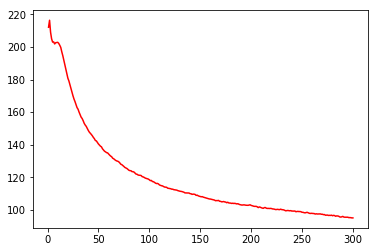

In [16]:
x=np.linspace(1,300,300)
print(x)
y=np.array(nctm.perplexity)
plt.plot(x,y,'-r')
plt.savefig('topic20')

In [ ]:
brand_topic=brand_to_topic(good_Coordinate_input,nctm.Z)
tag_topic=brand_to_topic(good_tag_input,nctm.Y)

#topicごとにブランドとトピックの組をまとめる
brand_topic_list=brand_topic_list_f(brand_topic,K)
tag_topic_list=brand_topic_list_f(tag_topic,K)

#トピックごとに出現ブランドのセットを作る
t_setlist_brand=t_setlist_brand_f(brand_topic_list,K)
t_setlist_tag=t_setlist_brand_f(tag_topic_list,K)

# 各トピックごとのサイズの確認
TopicBrandSize=[]
TopicTagSize=[]
index=[]
for i in range(len(t_setlist_brand)):
    TopicBrandSize.append(len(t_setlist_brand[i]))
    TopicTagSize.append(len(t_setlist_tag[i]))
    index.append(i)
print(TopicBrandSize)
print(TopicTagSize)

In [ ]:
#0になっているタグを除去しないといけない．0になっているタグもトピックに分配されてしまっている
# print(nctm.R[0:100])

In [11]:
#セットを用いて出現回数をカウント
count_topic_brand=count_topic_f(brand_topic_list,t_setlist_brand,K)
count_topic_tag=count_topic_f(tag_topic_list,t_setlist_tag,K)

In [12]:
#結果の書き込み
import pandas as pd
write_result('brands.csv',t_setlist_brand,count_topic_brand)
write_result('tags.csv',t_setlist_tag,count_topic_tag)

END
END


In [14]:
# ノイズ配列の保存
import csv
output('nctmR.csv',nctm.R)

In [14]:
## ノイズと判断されたものについて
noise_list=[]
for r,tag in zip(nctm.R,X):
    for r0, tag0 in zip(r,tag) :
        print(r0,tag0)
        if(r0==0):
            noise_list.append(tag0)

1 562
0 966
0 687
0 2457
0 966
0 394
0 990
0 86
1 2969
1 3216
0 2875
0 928
1 3038
1 2539
0 1050
0 1409
0 2932
0 491
0 2633
0 2875
0 373
0 928
0 526
0 1986
0 2377
0 2900
0 1050
1 23
0 2874
1 244
0 2179
0 2515
0 2507
0 2142
0 736
0 736
0 1941
0 2552
0 456
0 3043
0 2849
0 1578
0 1764
1 2742
0 1635
0 1044
0 2821
0 1284
1 357
1 150
0 1769
0 1314
0 401
0 2259
0 138
0 2145
0 827
0 2294
0 1368
0 736
0 1409
0 2965
0 872
0 1770
0 2014
0 2747
0 651
0 1394
0 2339
0 928
0 966
0 958
1 2676
1 301
1 2164
0 724
0 966
0 1398
0 2417
0 1314
0 1644
0 367
1 1408
0 406
0 1052
1 1065
0 736
1 2153
0 373
1 1977
1 1677
0 494
0 966
1 188
0 928
0 736
0 871
1 2747
0 1941
0 564
1 225
0 1660
1 2352
0 197
1 1848
1 509
0 966
0 1281
0 2008
0 1202
1 1352
0 928
0 736
0 1725
1 1301
0 730
0 401
0 507
0 966
1 424
0 659
1 1188
0 2377
1 1302
0 928
0 736
0 871
0 925
1 3195
0 1619
0 1820
1 2698
1 2610
1 2176
0 373
0 709
0 1201
0 769
0 2190
0 1890
0 966
0 2876
0 966
0 394
0 1281
0 3108
0 1398
0 2507
0 3191
0 495
0 1789
0 928
0 33

0 2779
1 2722
1 1598
1 1921
0 1068
0 966
0 990
0 456
0 2417
0 2721
1 9
0 1625
1 371
0 143
0 2015
1 1037
1 474
0 1635
0 143
0 1451
0 1314
0 1578
0 394
0 2875
0 373
0 1725
0 2058
0 2123
0 928
0 871
0 1451
0 1563
0 2366
1 1459
0 1644
1 288
1 145
1 1346
0 1789
0 1987
1 2708
1 225
1 111
1 1625
0 928
0 736
0 1635
0 871
0 1368
0 1619
0 3117
0 2721
0 2507
0 1677
0 889
0 494
0 15
0 1384
1 1634
1 1233
0 2507
0 966
0 40
0 871
0 2876
0 928
0 1724
1 1773
1 2708
0 1007
0 966
0 394
0 928
1 617
0 1301
1 3132
0 928
0 330
0 3028
1 474
0 1368
0 2082
0 2789
0 2058
0 394
0 966
0 1398
0 928
0 2417
0 373
0 3165
0 377
0 1451
0 2230
0 1635
1 2119
1 455
0 564
1 1020
0 1764
0 2109
1 1990
0 1574
0 966
0 149
1 1810
0 928
0 1398
0 3044
0 2058
0 394
1 301
0 1941
0 2797
0 1281
0 928
0 929
0 149
0 143
1 2319
0 197
1 474
1 2373
0 1295
1 3038
0 394
0 367
0 564
0 2876
0 736
0 1753
0 2109
0 330
0 2709
1 2169
1 2499
1 2168
0 2747
1 1980
0 1370
0 736
0 1368
0 928
1 2958
0 2803
0 651
1 2708
0 1314
0 2639
1 1137
1 2701
1 1215

1 713
0 2922
1 3100
1 821
0 1644
1 198
1 1325
1 2529
1 1030
0 197
0 1644
1 3104
0 3023
1 2735
1 2807
0 2626
1 2195
1 1076
1 2529
0 928
0 736
0 1941
0 1368
0 651
0 401
0 382
0 1280
0 2789
0 2875
0 1848
0 1725
1 1821
1 162
0 1941
0 871
0 1879
0 1281
0 2259
1 1280
0 2849
0 2365
0 2321
1 1422
0 1848
0 1725
1 1821
1 162
0 1753
0 1236
0 2253
0 1644
0 2109
0 2876
1 1046
0 1677
0 494
1 738
1 67
0 928
1 2584
0 3052
0 1893
0 1941
1 1656
0 928
1 785
0 86
1 374
1 215
0 1987
1 2052
0 1644
1 828
0 928
0 871
1 2747
0 651
0 1986
1 2525
0 956
0 504
0 928
0 736
0 1941
0 871
0 1202
0 143
1 3038
1 1821
1 162
0 1834
1 2445
1 1821
1 162
0 928
0 2853
0 2254
0 406
0 1181
0 111
0 253
0 1644
0 2365
0 1052
1 1325
1 2785
1 1644
1 2224
0 1987
0 928
1 1578
1 1370
1 2755
0 2379
0 2789
0 1451
0 1314
0 401
0 1941
0 507
0 871
0 1202
0 1281
0 2789
0 2812
1 480
0 2754
0 928
0 928
0 966
0 367
0 1368
0 651
0 2469
0 871
0 1451
0 928
1 922
0 697
0 504
0 687
0 367
1 1550
0 564
0 1384
0 457
1 665
0 1603
0 1368
0 2797
0 149
0 5

1 1132
0 1174
0 172
0 2803
0 2058
0 1764
0 2367
0 1314
1 2856
1 2777
0 143
0 394
0 2849
1 944
0 871
0 2876
0 966
1 3096
0 1202
0 1301
0 928
0 2109
0 907
0 1008
0 2898
0 1941
1 1755
0 966
0 1383
1 872
1 1422
1 292
1 1552
1 3204
1 1132
0 495
0 1314
0 2721
0 2755
1 1215
0 112
0 966
0 2552
0 2876
1 1137
1 3204
0 276
0 1879
0 3108
0 615
0 1677
0 1501
1 1163
0 928
0 1941
0 1368
0 615
1 1820
0 3028
0 901
0 197
0 2751
0 928
0 1941
0 1202
1 1439
0 1298
0 1619
0 394
0 736
1 923
0 2283
0 1753
0 526
1 1887
1 1109
0 2874
1 1453
1 2524
1 1672
1 2887
0 1236
0 928
0 1941
0 394
0 1281
0 1202
0 1368
0 1407
0 1301
0 928
1 1194
1 2087
1 518
1 2500
1 2229
1 1571
1 2354
1 2366
0 928
1 860
0 928
0 1368
0 1941
0 1314
0 1677
0 2749
0 373
1 3038
0 1947
1 2469
0 1644
0 1036
1 1742
0 1937
1 3217
0 1941
0 1398
0 1619
0 495
0 1993
0 474
0 2720
0 526
0 705
0 2058
0 1949
1 1873
0 367
0 1416
0 841
0 1941
0 394
0 1603
0 1451
0 928
0 1941
0 3108
0 651
0 1451
0 2319
0 126
1 1994
0 564
0 526
0 1113
0 2633
1 1887
1 1109
1 

0 1368
0 394
1 2308
0 1174
0 246
1 1647
0 1202
0 1578
0 872
0 811
0 1941
0 928
0 394
0 377
0 1368
0 2253
1 41
0 2797
0 850
1 1818
0 1036
0 1082
0 2417
1 1215
1 710
0 928
0 1941
0 1764
0 1281
0 1574
0 394
1 1725
1 1708
0 1834
1 1215
0 1482
1 67
0 1045
0 2109
0 615
0 2875
0 2072
0 1584
0 143
1 1242
1 1873
0 1725
0 928
0 871
0 1603
1 1711
0 1895
0 1769
1 576
0 615
1 2556
1 803
0 1438
0 1309
1 2806
1 2874
1 23
0 1774
0 1366
0 1789
1 1865
0 2797
0 1368
0 1941
0 3108
0 1036
1 1287
0 143
0 626
0 978
1 1856
0 928
0 1368
0 966
0 2008
0 1314
0 2751
0 1438
0 1774
1 1793
1 572
1 1954
1 903
0 1319
0 1314
0 1941
0 2552
0 3108
1 1766
0 1789
1 3031
1 2331
0 1398
1 1636
0 3052
0 3108
0 1315
0 1758
0 1577
0 2721
1 73
0 1368
1 2476
1 1555
1 373
0 3165
0 2821
0 233
0 394
0 1603
0 1281
0 1711
1 2123
0 1619
0 2321
0 3110
0 495
0 507
0 929
0 526
1 1055
0 1201
0 357
0 928
0 1941
0 394
0 401
0 990
0 1368
0 1941
1 3062
0 2515
0 491
0 1281
0 1941
0 966
0 149
0 400
1 1672
1 2887
0 1368
0 1304
0 2876
0 925
0 1366


0 1181
1 1284
1 2601
0 406
0 2417
0 928
0 907
1 2852
1 1009
0 1941
0 2507
1 2849
0 1644
0 1578
1 789
1 1873
1 1873
0 3052
0 674
0 401
0 2965
1 415
0 2721
0 2789
0 2812
0 1113
0 1941
0 1753
0 394
0 1941
0 53
0 1574
0 2287
0 1774
0 1508
0 928
0 736
0 1368
0 1941
0 966
0 925
0 1753
0 736
0 1789
0 153
0 1368
0 1236
1 2913
0 2010
1 1251
1 2027
0 2797
0 504
0 1368
0 1941
0 709
0 928
0 394
0 2639
0 1309
0 1941
0 966
0 2366
0 1753
0 736
0 1983
0 1368
1 781
0 2979
1 1239
0 2876
0 253
1 698
1 1943
1 634
0 1584
1 1236
1 1137
1 2701
0 1159
1 2016
1 529
1 2584
1 1458
0 1133
0 966
0 1753
0 1366
1 736
0 1789
0 1724
0 2976
1 1947
1 2797
0 928
0 1368
1 2849
0 394
0 1413
0 925
1 2831
0 1314
0 783
0 456
0 1753
0 2598
0 1619
0 442
0 736
0 1789
0 2726
0 564
0 783
0 2979
0 2876
1 742
0 2073
0 1764
1 1834
0 872
0 2789
0 2849
0 1753
1 2754
1 1370
0 928
0 1368
0 394
0 1941
0 2058
0 871
0 893
0 1508
0 928
0 736
0 1398
0 1368
0 1314
0 1941
0 966
1 2354
1 2366
1 197
0 149
0 1753
0 736
0 1368
0 928
0 651
1 935
1 1

0 928
0 1619
0 1773
0 1941
0 1941
0 2789
0 1174
0 1314
0 3084
0 2417
1 2584
1 2701
1 1873
1 1215
0 1482
0 1941
0 966
0 504
0 495
0 2311
0 928
0 1941
0 394
0 966
1 373
0 2572
0 2377
0 2721
0 2588
0 2311
1 795
0 2569
0 2230
0 2875
0 373
0 2909
1 865
1 720
0 928
1 339
1 3033
0 928
0 1368
0 2912
1 1873
1 67
1 1226
0 811
0 2721
0 457
0 1301
0 1202
0 928
0 1941
0 1368
0 1309
0 1314
0 929
0 377
0 394
0 2875
0 739
0 1368
0 841
0 966
0 1079
0 1284
0 394
0 1174
0 298
0 1639
0 1644
0 1036
1 2869
1 3085
1 2468
0 1848
1 1215
0 966
0 928
1 1180
1 419
0 504
0 1941
0 881
0 2417
0 2721
1 2597
0 928
0 1368
0 1941
0 1314
0 1753
0 1206
0 1413
0 3111
0 1644
0 928
1 1132
1 2701
1 732
1 1873
1 67
1 1482
0 3108
0 281
0 872
0 966
0 2545
0 1654
0 1201
0 928
1 2861
0 1368
1 1873
1 1215
1 1482
1 1226
0 1079
0 1879
0 966
0 504
0 1314
0 406
0 2875
0 2797
0 850
0 394
0 928
0 1619
0 739
0 1174
1 2457
0 1484
0 1314
0 709
1 2776
0 928
0 1368
0 1941
0 367
0 925
0 1366
0 456
0 3108
1 1226
0 164
0 907
0 615
0 820
0 1563
0

0 928
0 1368
0 1941
0 3108
0 57
1 701
0 2507
0 143
0 491
1 2139
0 1314
0 1393
0 1619
1 2540
0 1398
1 435
0 1941
0 966
0 1753
0 928
0 736
1 2696
0 1789
1 379
0 1368
0 1236
0 1644
1 1490
0 1617
1 2210
1 2537
0 1644
0 928
1 1168
1 1432
1 1363
1 1665
0 1246
0 2366
0 2377
0 1368
0 497
1 1215
1 1873
0 1482
0 3108
1 54
1 3204
0 2803
0 1299
1 439
1 2681
1 1080
0 2907
0 1711
0 1848
0 928
0 367
0 3176
0 394
0 928
0 1941
0 1368
0 1574
0 2721
0 2853
1 1
0 1099
0 2008
1 1062
1 2025
1 967
1 2611
1 766
1 1980
1 2217
0 260
1 1577
0 1181
0 1368
1 2530
0 2062
0 1654
0 1537
0 929
0 1993
0 143
0 2638
0 2311
0 928
0 1368
0 2797
0 1724
0 2922
1 1933
1 1259
0 123
0 1941
0 841
0 1133
0 1314
0 928
1 2498
1 2125
1 1186
0 651
0 373
0 1466
1 277
1 3046
1 2103
1 884
0 871
0 495
0 2507
0 373
1 3038
1 1135
1 1
0 564
0 1619
0 2542
1 1062
1 967
0 576
0 871
0 635
0 925
0 1516
0 1774
1 572
1 903
0 1368
1 1834
0 1941
1 2849
1 1578
0 3052
0 1619
1 2754
0 1820
1 1097
0 1983
0 966
0 1964
1 989
0 2876
0 925
1 462
0 1284
1 16

0 256
0 2170
1 1254
0 2321
0 1368
0 1625
0 394
0 1314
0 3165
0 2875
0 1711
0 1202
1 1214
0 2876
0 929
0 1941
0 1941
0 1368
0 1281
1 2341
0 1644
0 1036
1 2626
1 198
0 2876
0 26
0 1368
0 928
0 401
0 2797
0 3108
0 966
0 2853
0 925
1 1749
0 1941
0 394
0 1281
0 1202
1 2302
0 401
0 925
0 2979
0 2062
0 660
0 1368
0 1941
0 928
0 925
0 615
0 1619
0 1281
0 928
0 1368
0 1941
0 1366
0 1201
0 1335
0 149
0 2008
0 1314
0 147
0 1574
0 2875
0 1360
0 2293
0 1105
0 966
1 1913
1 1332
1 67
0 3108
1 2584
0 495
1 2303
0 3108
0 2365
0 564
0 2250
0 373
0 907
0 281
0 2721
0 2308
0 2448
1 1953
0 1635
0 1644
0 2321
0 1036
1 1901
0 1368
0 3108
0 123
0 373
1 56
1 504
0 149
0 2010
0 2131
0 1619
0 1724
0 1368
0 1368
0 1806
1 442
1 1466
0 2602
0 925
0 138
0 2797
0 990
0 564
0 687
0 393
0 2058
0 1082
0 2682
0 2598
0 2721
1 474
0 1769
0 1941
0 966
0 494
0 2849
0 871
0 2470
0 698
0 126
0 1915
1 639
0 1368
0 1753
0 966
0 3019
1 790
1 83
1 1215
1 67
1 1132
0 1398
0 1724
0 2849
0 2754
0 2515
0 281
0 3183
1 2903
1 646
1 2269

0 1199
0 1937
1 2626
1 1215
1 3204
1 1226
0 1879
0 2721
0 1281
0 1941
0 2131
1 986
0 3108
0 1635
0 1626
1 2677
0 1398
1 1215
0 401
0 2721
1 1913
0 1724
1 2400
0 615
0 1279
0 2598
0 1532
0 928
1 1137
1 67
1 1132
0 526
1 547
0 1416
0 229
0 1834
0 2578
0 1201
1 769
0 871
0 2812
0 928
0 966
0 1201
0 736
0 871
0 1202
0 2572
0 2131
0 730
0 1764
0 2911
0 373
0 3111
0 1314
1 1834
0 1941
0 615
1 1578
1 1299
0 1619
1 2754
0 1366
0 928
0 928
1 1888
0 1368
1 1215
1 1873
1 1482
1 3204
0 3108
1 54
1 1132
0 2849
0 143
0 394
0 394
0 2747
0 871
0 1574
0 1314
0 978
0 2559
0 2554
0 1366
0 2321
0 1279
0 841
0 1806
0 2875
0 2230
0 495
1 2638
0 928
0 1941
0 373
1 1038
1 3035
0 3030
1 1215
1 1873
1 1482
1 67
1 1226
0 3108
0 907
1 2584
1 1747
0 928
0 1941
0 394
0 1368
0 1574
0 373
1 593
0 564
0 736
0 1774
1 1215
0 615
1 1195
1 51
1 734
1 1585
0 966
0 1753
0 1774
0 2457
0 736
0 260
0 2321
0 1368
1 1397
1 1236
1 1790
1 1513
0 2632
0 1941
1 793
0 2876
0 1644
0 1687
0 2721
0 1941
1 564
0 615
0 3023
0 1578
0 1820


0 2499
0 1941
0 615
1 24
0 925
0 1753
0 1789
0 2360
1 207
1 180
0 3108
1 67
0 2039
0 1409
0 680
0 1398
0 1993
0 1133
0 2104
1 1137
1 67
1 1823
1 2584
0 1941
0 281
0 2789
0 3165
0 394
0 1654
0 928
0 1753
0 1368
0 1941
0 2109
0 1764
0 925
0 143
1 2339
0 928
0 1764
0 2789
0 377
0 2261
1 1308
1 937
0 2294
0 1384
0 2616
0 2638
0 1977
0 2802
0 1820
0 1137
0 2797
0 1941
0 3090
0 1281
1 2447
1 1215
1 67
1 1137
1 1913
1 3127
1 2289
0 1993
0 2721
0 1941
0 3108
0 1724
0 491
1 1145
0 1281
0 1335
0 1235
0 2360
0 2612
0 1877
0 2552
1 2769
0 1281
0 3108
0 143
0 928
0 2721
0 1792
0 928
1 142
0 1079
0 1314
0 925
1 815
0 1368
0 1753
0 2417
0 1870
0 1770
0 872
0 928
0 1368
0 1619
1 1270
1 380
1 915
0 1743
1 2350
1 1685
1 2683
1 1009
0 1368
0 615
0 2294
0 677
0 373
1 22
1 790
1 504
0 2775
0 928
0 394
0 1368
0 1281
0 1711
0 1774
0 1654
1 1563
1 1460
0 783
0 1753
0 1617
1 1795
0 1774
0 1366
0 928
0 736
0 1368
1 1236
0 928
0 143
1 2552
0 1054
1 2769
0 1792
0 2259
0 2131
0 1281
0 2876
0 3083
0 1753
0 462
0 73

0 1044
0 1941
0 2425
0 1109
1 1766
0 1880
0 297
1 2331
0 1398
1 1222
1 1215
1 1873
1 3204
1 54
0 2515
0 697
0 2790
0 1368
1 1131
0 651
0 1202
1 1277
0 2797
0 1941
0 1314
1 1339
1 781
1 1239
0 2876
0 1366
1 2170
1 510
0 2726
1 634
1 1215
1 54
0 1724
1 3204
1 2584
0 2721
0 2294
0 2791
0 2803
0 1201
0 1941
0 966
0 709
0 925
0 1753
0 1635
0 736
1 1126
0 2321
0 1368
0 1044
0 871
0 138
1 1806
0 1753
0 1953
0 928
0 1724
0 1473
0 769
0 928
0 1368
0 2797
0 2109
0 1466
0 2321
1 2939
0 373
1 1064
0 1314
0 1774
1 675
1 176
1 2322
0 394
0 1941
0 1201
0 1753
0 253
0 841
0 928
0 2797
0 1368
1 1236
0 928
0 615
0 1644
0 1314
0 990
1 2925
0 576
1 416
0 2726
1 2272
0 1384
0 1953
0 504
1 1337
0 2031
0 736
0 1941
0 2153
0 928
0 928
0 1368
0 1941
0 143
0 659
0 2377
1 329
0 1079
0 1941
0 3102
1 2890
0 1792
0 1619
0 494
0 2876
0 1764
0 697
0 2912
1 2231
0 253
1 788
1 3030
0 1201
0 769
0 1368
0 143
0 330
0 30
1 290
0 1281
0 2418
0 1753
1 2008
1 126
0 1398
0 1036
0 1368
1 1236
1 2469
1 2045
1 1715
0 709
1 840
0

0 1769
0 382
1 2743
0 1619
1 1178
0 1789
0 1368
1 435
0 928
0 1368
0 1941
0 1201
0 1366
0 2797
1 2874
1 2806
1 3159
0 138
0 1314
1 53
0 2015
0 1807
0 928
1 2958
0 871
0 928
0 1941
0 1368
0 1635
0 1773
1 935
1 694
0 1036
0 1644
1 2518
0 928
0 394
1 111
0 2321
0 1574
0 1807
0 2849
0 2751
0 1941
0 987
0 2812
0 1314
0 1281
0 1941
0 2616
0 1201
0 1366
0 928
1 1583
0 1368
0 1941
0 1753
0 2797
0 3006
0 1635
0 966
0 928
0 1368
0 1941
0 1201
0 143
0 1366
0 907
0 1284
0 1314
1 1215
1 67
1 1873
0 928
0 2875
0 2515
0 930
1 1482
0 1764
0 2791
1 2375
0 1941
0 2365
1 3078
0 1088
1 903
0 871
0 1574
0 1314
0 394
0 2705
0 1247
0 2142
0 810
0 504
0 2797
0 2417
0 1314
1 1211
0 928
1 2786
0 394
1 292
0 966
0 1635
1 1578
0 651
0 2849
0 966
0 1368
0 1724
0 2365
0 2907
0 1711
1 1154
0 143
0 1202
0 394
0 1941
0 928
0 1368
0 1314
0 1113
0 336
0 1764
0 1366
0 928
0 1774
0 1201
0 1941
0 1368
0 709
1 2735
1 2601
0 1753
0 1482
0 1215
0 928
0 1368
0 401
0 1201
0 2311
0 2638
0 2080
1 2661
1 742
1 1189
1 2857
1 2961
0

1 176
0 1092
0 2109
0 330
0 928
0 2876
0 373
1 2731
0 1941
0 101
0 840
1 67
1 1215
1 2676
1 22
0 1586
1 737
0 504
0 715
1 951
1 940
1 420
0 2145
0 2721
0 2979
0 1394
0 494
1 2817
0 1941
0 143
0 401
0 1314
0 394
0 3096
0 1953
0 966
0 1635
0 3182
0 928
1 1064
1 225
0 2853
1 2501
0 1368
0 1368
0 2911
0 253
0 1644
0 1281
1 790
1 2723
0 1099
0 1133
0 615
1 2706
0 526
0 803
0 1148
0 385
0 1952
0 373
0 253
0 1941
0 1368
0 504
0 925
0 928
1 601
1 1549
0 1503
0 1603
0 966
1 1202
0 1941
0 928
0 928
1 785
0 2321
0 615
0 1806
0 400
0 2072
0 2311
0 138
0 377
0 1284
0 2044
0 928
1 2390
1 1218
0 1236
1 2675
0 2417
0 1774
0 1366
0 928
1 1283
1 301
0 928
0 1314
0 1105
0 361
0 3165
0 456
0 394
0 1368
0 966
1 2962
0 1711
1 1407
0 928
0 394
0 1774
0 697
0 956
1 825
0 2177
0 813
1 316
0 1532
0 929
0 2705
1 292
0 928
0 1941
0 925
0 2230
0 1181
0 1281
0 3096
0 394
0 928
0 1368
0 1941
0 2109
1 1796
0 153
0 2721
1 1578
1 2232
0 1281
0 1625
0 394
0 1202
0 1774
0 1368
0 2308
0 928
0 2044
0 2366
0 1941
0 23
1 186

0 1644
0 2039
0 928
0 1941
0 1398
0 1993
0 3108
0 1281
0 564
1 2634
1 403
0 651
1 1821
0 1725
0 1368
0 2507
1 3011
1 2521
1 2185
0 1774
0 966
0 928
1 2487
0 1574
0 1774
0 928
0 1281
0 1202
0 1879
0 1314
0 3096
1 2469
1 1759
0 1215
0 1879
1 427
0 1368
0 928
0 2507
0 377
0 907
0 172
0 493
1 2229
0 1314
0 925
0 2366
1 1852
0 576
0 1368
0 928
0 1941
0 1366
1 2375
1 970
0 2844
1 1058
0 1368
0 2109
0 143
0 1394
0 2797
0 841
0 1281
0 2010
0 1314
0 1777
1 1215
0 1482
1 67
0 820
0 956
0 2720
0 615
1 889
0 2925
0 1644
0 1036
0 3104
1 1268
0 2978
0 803
1 352
0 1325
0 928
0 1281
0 1941
0 143
0 1201
0 871
0 1644
1 98
1 121
0 1199
1 911
0 1604
0 494
0 2501
0 1941
1 18
0 253
0 724
0 651
1 1807
0 1907
0 659
1 3140
0 2470
0 830
0 1133
0 783
1 2482
0 2307
0 925
0 401
0 1360
0 2754
0 2259
0 1941
1 1215
0 1482
1 3204
0 2365
1 3153
1 1298
1 577
1 3002
0 1503
0 2853
0 1174
0 925
1 3177
0 1281
0 394
1 2669
0 2058
0 394
0 1574
0 928
0 2579
1 3040
1 1887
0 364
1 2567
0 3129
0 2598
0 138
0 197
0 615
0 406
0 336

0 394
1 62
0 1202
0 929
0 1413
0 1368
0 736
0 1941
0 2721
0 493
0 495
1 2885
0 456
1 1931
0 2797
0 1368
0 1366
1 235
0 2391
0 526
0 2577
1 2045
0 1036
0 138
0 2226
0 928
0 82
0 143
0 1368
0 1941
0 1368
0 1644
0 2321
0 504
0 2340
1 2633
0 2230
0 709
0 925
0 1774
1 1861
0 2726
1 205
1 1210
1 2349
1 2826
1 2308
1 1980
1 2225
0 966
1 1578
0 1941
0 2803
1 1336
1 1269
0 987
0 394
0 1774
1 300
0 928
0 1368
0 1941
0 1366
0 1201
0 367
1 1876
1 830
1 2124
1 1965
1 292
1 2865
1 1578
1 157
0 394
0 928
0 1574
0 1281
0 1174
1 3204
0 1764
0 576
0 2721
0 928
0 966
0 1724
0 504
0 889
0 925
0 1314
0 1574
0 143
1 1444
1 3173
1 1070
0 1941
0 966
1 1475
0 2417
0 394
0 1574
1 2058
0 928
0 811
1 2063
1 668
0 2598
1 2802
1 2105
1 1137
1 3063
1 2701
1 1163
0 928
0 1941
0 1393
0 1711
0 2638
0 2682
0 1451
0 2117
0 526
0 928
0 2072
0 3165
0 2261
0 1281
0 1438
0 2311
0 504
0 966
0 925
0 928
0 723
0 2598
0 1398
0 1368
1 2336
1 2164
1 2869
0 1834
0 1769
1 2679
0 576
0 2062
0 3084
0 2366
1 2103
1 6
0 492
0 2721
0 206

0 149
0 1181
0 928
0 1617
0 1368
1 1602
1 54
1 1137
0 1941
0 928
1 1843
1 1814
0 928
0 1368
0 1941
0 1201
0 2747
0 2682
0 504
0 1368
0 928
0 143
0 709
0 1314
0 2321
1 2936
0 2448
0 723
1 884
0 2721
1 67
1 2584
1 1180
0 1130
0 928
0 966
1 2778
1 197
1 1704
1 2692
1 2136
0 2935
0 495
0 1516
0 1858
0 378
0 928
0 928
1 263
0 1293
0 1711
0 101
0 1719
0 1941
0 928
0 1281
0 1130
0 615
0 1711
0 504
0 1368
0 2789
0 1314
0 143
0 1789
0 1941
0 1201
0 1635
0 1644
0 1848
0 394
0 1202
0 2572
0 564
1 113
1 1357
1 136
0 2874
1 1865
0 977
0 526
1 244
0 2346
0 928
0 1281
1 2438
0 394
0 1281
0 564
0 925
0 1619
0 394
0 2308
1 2870
0 1202
0 1113
0 1753
1 67
1 2584
0 3108
0 928
0 1368
0 1941
0 1366
0 1201
1 462
0 1181
0 2072
0 2311
1 1712
0 1941
0 1466
0 2062
0 2058
0 533
0 138
0 626
0 2039
1 790
1 2849
0 929
0 2058
0 401
0 394
0 2875
0 1281
0 1774
0 1711
0 1644
0 1036
0 3104
0 2111
1 1589
1 2224
0 1199
0 1202
0 638
1 2939
0 1766
0 2789
1 2657
0 928
0 1044
0 310
0 1574
0 1281
0 1202
0 2789
0 2747
0 3165
0 9

0 401
0 1941
0 1368
1 2601
0 928
0 1895
0 2417
0 2340
0 2177
0 1281
0 491
0 1644
0 966
0 1724
0 1941
0 1398
0 564
0 1368
0 1753
0 928
0 1368
0 1366
1 1286
1 434
0 966
0 394
0 1201
0 871
0 2058
0 651
0 1711
1 506
1 1379
1 158
0 1619
0 197
1 853
0 1603
0 1711
0 2849
0 3159
0 2876
0 1660
1 848
0 1574
1 813
1 2140
0 928
1 2672
0 928
0 1368
0 1753
1 373
0 2377
0 1366
0 1368
0 1941
0 1366
0 1774
0 30
0 2515
0 2616
1 395
1 2727
0 1279
0 2853
0 1662
0 1281
0 1130
0 615
1 270
0 1964
0 2876
0 736
0 2742
0 564
0 1314
0 615
0 872
0 1368
0 3113
0 928
0 1368
0 1941
0 1366
0 1201
0 1774
0 709
1 1266
0 373
1 2246
0 2812
0 2789
0 928
0 1368
0 1774
1 3
0 1711
0 526
0 1314
0 2104
0 533
0 2876
0 1578
0 1370
0 2572
1 1362
0 2768
0 2789
0 1451
0 739
0 2109
0 1486
0 2170
0 3052
0 1941
0 1281
1 1962
0 197
0 1314
0 1725
1 373
0 1121
1 2862
1 2962
0 1054
0 1099
0 928
0 1368
0 1335
0 1769
0 1619
0 2821
1 1825
0 101
0 1619
0 394
1 520
1 1853
0 1202
0 373
1 943
0 1711
0 830
0 1625
0 928
0 1201
0 1603
0 3165
0 2552

0 1050
0 2554
0 1366
0 1635
0 1201
0 2791
0 1916
0 1941
0 2797
0 928
0 1368
0 1941
0 1366
1 1827
1 2197
1 1493
1 21
0 101
0 2638
1 2153
0 367
0 2145
0 1368
0 2109
0 495
0 928
0 2876
0 2789
0 651
0 1941
0 394
0 2922
0 3096
1 2610
0 1368
1 2252
1 955
0 785
0 456
0 2552
0 3165
0 1941
1 2184
0 2321
0 3104
1 92
0 1724
0 2721
0 1279
1 1657
0 1202
0 373
1 2176
1 1215
1 67
1 1132
1 1382
0 1431
1 2514
0 3176
0 246
0 928
0 709
0 1986
0 1677
1 2922
0 2789
0 2876
0 1201
1 2747
0 504
0 1774
0 1774
0 1574
0 1281
0 1368
0 1314
0 2131
0 1202
1 197
1 1888
1 81
1 1294
1 3140
0 1644
0 1036
1 1881
0 2626
1 1834
1 1922
1 747
1 2143
0 1133
0 2721
1 1629
0 783
1 1070
0 928
0 925
0 526
0 281
0 2117
0 615
1 1215
1 1482
0 2092
1 577
1 1200
1 466
0 2418
0 281
1 67
1 1823
0 928
0 1368
0 925
0 3013
0 907
0 367
1 373
0 2900
0 1137
1 67
0 925
1 474
0 2721
0 928
0 1368
0 401
1 1513
0 1941
0 1314
0 491
0 811
0 2626
0 1644
0 1941
0 966
0 1201
0 1677
0 928
1 1215
0 1482
0 1309
1 54
1 3204
0 907
1 1215
1 1482
0 3108
0 21

1 227
0 1281
1 2086
1 389
0 1807
1 2054
1 2207
1 3038
0 1563
0 456
1 1646
0 1619
0 2230
0 1941
0 966
0 928
0 1941
0 1724
0 709
0 143
0 739
0 1079
0 2875
0 1201
0 1711
0 2545
0 2789
0 615
0 2876
0 1879
0 1281
0 2616
1 1952
0 1199
1 1432
1 2823
0 1398
0 1789
0 969
0 2922
0 26
0 928
0 1368
0 1941
0 394
0 1314
0 373
1 504
0 2797
0 1366
1 987
0 1774
0 1574
0 394
0 3165
0 1314
0 1644
0 1036
0 1199
0 966
0 2109
0 1366
0 928
0 1774
0 1368
0 1281
0 1758
0 1986
1 1380
0 966
0 1644
1 541
1 198
1 1882
0 1366
0 1941
0 1368
0 2554
0 281
1 810
0 406
0 2377
0 1486
1 373
0 2797
0 928
0 1366
0 615
0 709
0 138
0 367
0 373
0 1774
0 1199
0 1644
0 1578
0 2104
0 956
0 2321
0 966
0 1309
1 2463
0 1574
0 394
1 174
0 1201
0 1368
0 1109
0 1281
0 1711
1 1807
0 1941
1 2541
1 3195
0 1625
0 1503
0 1774
1 197
0 1677
0 2747
0 928
0 2876
1 1746
0 1711
0 2014
0 2876
0 2812
0 373
0 1202
0 491
0 336
0 1941
0 2321
0 3131
0 2072
0 2797
0 1774
0 1202
0 1301
0 1574
1 2520
0 966
0 2377
0 1314
0 680
1 2861
0 358
1 890
0 1719
0 2

0 2321
0 1941
0 2797
1 2939
0 1284
0 1577
0 1578
0 1370
0 2058
0 2849
0 1941
0 2554
0 1574
0 2709
0 2109
0 2058
0 197
0 1774
0 2015
1 2415
0 1792
0 1366
0 1774
0 2554
0 1619
0 1662
0 883
0 1236
0 2976
0 3003
1 423
1 1351
1 2809
0 197
1 739
0 2490
1 327
0 1986
0 2747
0 1619
1 22
0 889
0 1366
0 1366
0 1774
0 2554
0 2321
0 1753
0 1368
0 2157
0 2976
1 1417
1 2572
0 2286
1 2971
0 929
0 1284
0 2308
1 2849
1 1505
0 1719
1 1654
0 925
0 564
1 1659
0 576
0 2585
0 2339
0 925
0 1769
1 3204
1 1913
0 1215
0 1774
0 1654
0 3165
0 1619
0 149
0 2554
0 1366
0 2321
0 1789
0 2624
1 935
1 434
1 1286
0 1039
0 1366
0 1753
0 2554
0 1731
0 966
0 1635
0 1941
0 2849
0 1764
0 1451
0 1895
0 143
0 2875
0 504
0 1953
1 2596
1 2125
1 749
1 2961
0 2554
0 2721
0 1718
0 1753
0 2554
0 1174
0 1758
0 1314
0 2321
0 1368
1 1497
0 2797
1 1137
0 907
0 2377
1 881
0 393
1 399
1 1352
1 341
0 1281
0 2307
0 1366
0 1398
1 22
0 1130
0 394
0 406
1 975
0 1281
1 1776
0 2507
0 1537
0 2145
0 925
0 1753
1 935
0 401
0 615
0 1855
0 1314
0 1941

0 1438
0 1941
0 2876
0 377
1 253
1 822
0 1789
0 2747
0 1368
0 2749
0 1366
0 2554
0 143
0 925
0 1789
0 1314
1 1438
0 1941
0 966
1 1360
0 1753
0 377
0 1789
0 2747
0 1368
1 3068
0 143
1 25
0 1174
0 1774
0 1574
0 3165
0 1654
0 1199
0 2789
0 830
0 394
0 1314
0 2552
0 1834
0 872
0 1941
0 2062
0 2789
0 1578
1 355
1 1658
0 1215
1 54
1 2674
0 830
0 1907
0 1723
0 2789
0 1089
0 1774
0 1574
0 3165
0 456
0 966
0 2131
0 907
0 928
0 1769
0 1895
0 2876
0 3108
1 930
0 1986
1 1652
0 928
1 126
0 1398
1 788
1 1215
1 1482
0 1724
0 2853
0 2058
0 394
0 396
0 929
0 615
0 907
0 907
1 1215
1 1913
1 1137
1 1298
1 50
0 785
0 2638
1 67
1 881
0 1644
1 121
1 2396
1 2711
0 1941
0 2377
0 3097
1 641
0 1398
1 1215
1 54
0 615
0 495
1 3204
1 405
0 1314
0 2367
0 1438
0 3165
1 2117
0 2308
1 2807
0 1848
0 149
0 336
1 2077
1 2238
1 1902
0 373
0 1644
1 2984
1 831
0 925
0 1789
0 394
0 2015
0 1366
0 2554
0 2357
0 2946
0 1987
0 1774
0 1574
0 3165
0 1654
0 1199
0 1202
0 1301
1 854
1 2557
1 1521
0 709
0 497
0 1499
0 615
0 1202
0 11

1 102
0 1644
0 1036
1 2224
0 1201
0 769
0 651
1 1683
1 2023
0 1724
1 1215
0 2515
0 1993
0 495
0 2721
0 2321
0 925
0 1314
0 1953
0 1133
0 2876
0 2114
0 1753
1 3064
1 791
0 1654
0 1036
1 1212
1 2626
0 1725
1 803
0 2907
1 1433
1 2529
1 959
1 2678
0 2554
0 1644
1 2783
0 1635
0 1635
0 1113
0 2721
0 2554
1 248
1 2054
0 1366
0 1774
0 2986
0 1314
1 2938
1 1215
1 54
0 1482
1 2584
0 394
0 2507
1 3204
0 2812
0 394
0 1753
0 1466
0 928
0 1398
0 2321
0 1036
0 1368
1 2469
0 1774
0 1654
1 2366
0 1578
0 1644
1 176
0 1764
0 394
1 292
0 564
0 1769
0 1941
0 2876
0 1753
0 1619
0 928
0 1789
0 1398
0 1368
0 2554
0 1370
0 2554
0 709
0 2789
0 457
0 1215
0 1482
0 1724
1 734
0 3096
0 2925
0 2638
1 738
1 67
0 1314
0 1848
0 2849
0 1654
1 1578
0 1619
0 1774
0 1366
0 830
1 1198
0 1644
1 2824
0 197
0 687
0 1941
0 2377
0 138
0 925
1 2908
1 2688
0 1368
1 1957
1 1215
1 54
1 419
0 406
0 2803
0 1281
1 1401
1 2584
1 12
1 2354
1 513
1 1704
1 225
1 2366
1 2541
1 197
0 253
0 966
0 1724
0 1753
0 1368
0 394
0 1764
0 2791
0 373


0 1578
0 871
0 2876
0 1201
0 1753
1 2747
0 2529
0 1174
0 2058
0 1774
0 2876
0 1314
1 358
1 185
1 1165
1 2722
0 3150
0 2554
0 1201
0 1366
0 615
0 138
0 3165
0 1113
0 2311
0 709
0 730
0 960
1 1405
0 1314
0 615
0 1753
0 928
1 256
1 2830
0 709
0 2377
0 1806
0 138
0 966
0 1774
1 242
0 1113
0 564
0 1486
0 2058
0 956
0 2365
0 143
0 871
0 394
0 966
0 1368
1 54
1 1215
1 2584
0 3052
0 1578
0 3165
0 2876
0 2545
0 1299
0 2875
1 225
0 1603
1 2261
0 1181
0 2749
0 504
0 1806
0 2360
0 2751
0 394
0 2875
0 1644
0 1941
0 1036
0 377
0 1325
0 1281
0 1789
0 564
0 925
0 1314
1 1482
1 144
1 67
1 16
0 960
0 1366
0 2554
0 2321
0 1941
0 1635
0 1789
0 220
0 491
1 2370
1 1137
1 2701
0 241
0 1654
0 1644
1 1168
1 1432
1 1363
0 2554
0 1366
0 2321
0 1635
1 617
1 3132
0 2308
0 2157
0 1314
0 2515
0 1201
0 1366
0 736
1 1116
0 491
0 2153
0 197
1 87
0 709
1 1635
0 1366
0 2321
0 960
0 2554
0 966
0 1368
0 1652
0 1870
1 1137
1 881
1 1132
0 1724
0 2803
0 2554
0 2321
0 1635
0 1789
1 22
1 1622
0 1774
0 3165
0 1654
1 1574
0 2876


1 564
0 2058
0 394
0 3104
0 1366
0 2875
0 1335
0 253
0 564
0 394
0 1366
0 2321
1 2307
0 1724
1 3015
0 1335
1 1874
0 1789
0 1635
0 2501
0 1879
0 1635
0 1753
0 2554
0 1366
0 1635
0 1947
0 615
0 2010
0 495
0 1577
0 2876
0 3108
0 1986
0 928
0 1993
0 126
0 1398
0 2554
0 2797
0 638
0 1724
0 709
0 394
0 2109
0 1366
0 1482
0 1774
0 1368
0 30
1 330
0 2911
1 2029
1 1621
1 1352
1 976
0 82
1 1110
0 2554
0 1789
0 2876
0 564
0 929
1 2322
1 2735
0 1769
0 1619
0 442
1 269
0 57
0 2876
0 504
0 1753
1 197
0 1314
1 2747
0 966
1 1677
0 1724
0 907
1 881
1 734
1 1137
1 1215
1 1132
1 2278
0 2797
0 2554
0 2321
0 1635
0 1820
0 2721
0 1314
0 495
0 2875
0 2876
0 1654
0 2705
0 1941
0 504
1 1922
1 1764
0 1574
0 394
1 3184
0 3165
0 2876
1 1788
0 1314
0 1281
0 2311
0 2721
0 1619
0 1314
1 1848
1 2849
0 1113
0 1654
1 1578
0 2379
1 1125
0 2522
1 2755
0 2321
0 1635
0 1711
0 615
0 2230
0 1834
0 494
0 1281
0 401
0 928
1 722
0 1577
0 1451
0 3052
0 2965
1 1596
0 2797
0 143
0 1753
1 2300
0 1753
0 2747
0 966
0 564
0 2177
0 287

1 2245
0 1941
1 881
0 504
0 709
1 1132
0 2703
1 419
1 1724
1 1137
1 1215
0 929
0 1314
0 526
0 1941
0 966
1 352
0 1646
1 1335
0 928
0 143
1 989
0 1304
0 736
1 1821
1 162
1 345
0 2554
0 1314
0 1281
0 2922
0 1848
0 2721
0 2145
1 2108
0 2554
1 1635
0 925
0 709
0 2797
1 9
0 2875
0 394
1 2308
1 1980
0 1848
1 2225
0 1281
0 1941
0 2515
0 2876
0 1079
0 1753
0 928
0 1789
0 1398
0 1368
1 881
0 2058
1 51
0 871
1 2584
0 2554
0 1366
0 2321
0 1635
0 1789
0 1724
1 881
1 734
1 1031
1 2584
1 1579
0 1941
0 966
0 2321
0 783
0 730
0 297
0 1366
0 2721
1 3094
1 2251
0 1941
0 2797
0 2524
0 1789
1 1710
1 1932
1 1391
1 1042
0 2311
0 2821
0 929
0 1314
0 1281
0 526
0 1941
1 352
1 2261
1 1335
0 928
0 143
0 820
0 1309
0 2062
1 2575
1 3119
0 68
0 1202
1 1956
1 942
0 2311
0 1789
0 1368
1 2701
1 2584
0 1941
0 2721
0 1137
1 22
1 1913
0 492
0 2876
0 3108
1 1053
0 111
0 928
0 1789
1 795
1 126
0 2554
0 1334
0 1393
0 2109
0 1148
1 2771
1 855
1 1588
0 929
1 1913
1 1137
1 881
1 67
0 2365
0 1574
1 3201
0 739
0 2754
0 928
0 26

0 2109
0 871
0 2554
0 1366
0 1079
1 2878
0 564
1 1687
0 3003
0 1174
0 615
0 3117
0 966
0 1941
1 3216
1 914
1 1739
0 802
0 491
0 1413
1 22
1 1924
0 651
0 928
0 3130
1 2962
1 2969
0 2554
0 2321
0 1366
0 1789
0 1753
1 1943
0 2623
0 406
0 101
0 2554
0 2721
1 1820
0 2377
1 474
0 197
0 730
1 3107
0 3165
0 1578
0 925
0 2653
0 2876
1 1821
0 1314
0 2417
0 1941
1 352
0 2311
0 1654
0 925
0 1413
1 1626
0 2321
0 687
0 2875
0 1366
0 2554
0 1105
0 1174
0 394
0 651
1 1113
0 377
0 827
0 495
0 1763
0 3096
0 336
0 1281
0 1314
0 1281
0 3165
0 564
0 1574
0 2876
0 1503
0 925
0 1774
0 143
0 966
0 564
0 1201
0 1753
1 1282
0 2554
1 1969
1 1794
1 3081
1 644
0 2554
0 2321
0 1635
0 1789
0 1753
0 1398
0 1314
1 2448
0 260
0 1753
0 871
0 929
0 1953
0 1503
0 512
0 564
0 1174
0 1000
0 1806
0 394
0 1574
0 2789
0 1578
0 2876
0 1199
0 1774
0 507
1 1151
0 1368
1 1018
0 401
1 22
1 373
0 1451
0 2072
0 1366
0 2321
0 1635
0 615
0 1574
0 3165
0 1654
0 1725
0 2109
0 1413
0 576
1 1301
0 400
0 1941
0 966
0 1482
0 2373
0 1718
0 31

0 1574
0 2469
0 907
0 1941
0 2876
1 625
1 908
1 2404
1 2313
1 2755
1 1101
0 1281
0 2849
0 2979
0 2876
0 3108
0 930
0 928
0 126
0 123
0 2554
1 1790
0 3165
0 3159
0 2682
0 871
1 415
0 2876
1 2126
0 1654
1 22
0 2789
0 377
0 1652
0 2554
0 1789
0 1584
0 2321
0 1482
1 2226
1 377
1 2657
0 331
1 1489
0 2554
0 1635
0 1789
1 2815
0 2779
0 1088
0 2638
1 251
0 1314
0 966
0 2616
0 1366
0 928
0 2638
0 2321
0 1368
0 3160
0 2554
0 564
0 1314
0 615
1 336
0 1789
0 2321
0 2321
0 1635
0 1789
0 1619
0 385
0 1770
0 2554
0 149
0 1314
0 2321
0 1635
0 811
1 2078
0 143
0 2876
0 925
0 1314
1 2682
0 1941
0 966
1 352
1 2039
1 2545
1 2624
0 1503
0 1619
0 2876
0 1199
0 1325
0 1281
1 2507
0 2058
0 1314
0 2624
0 2875
0 1941
0 298
0 2391
0 281
1 2911
0 2062
0 2721
0 1941
0 928
0 2377
0 925
0 990
0 1281
1 1180
0 2058
0 495
1 388
0 680
0 2294
1 908
0 1398
1 2404
1 2313
1 2755
0 2749
1 1101
0 1202
0 2321
0 1635
0 2797
0 1711
0 373
0 2875
0 1281
0 1644
0 1036
0 1325
1 1989
1 2529
1 2398
1 2308
1 1980
1 79
1 2865
0 1774
0 1

0 1774
1 2812
0 394
0 1281
0 1677
0 2876
0 1753
0 1398
0 1036
0 1368
1 2469
0 929
1 2499
1 1253
1 1994
1 497
0 2768
1 2035
0 1941
0 2976
0 2554
0 1314
0 2230
0 615
1 2895
0 1953
0 2554
0 2321
0 1366
0 1635
0 1753
0 925
0 709
1 1181
0 1281
0 2876
0 1753
1 2117
1 2072
0 1398
1 1036
0 1368
1 2469
0 615
1 1702
1 1491
0 2912
1 3204
1 738
0 149
0 3052
0 1753
0 3108
0 1635
0 2294
0 1758
0 2876
0 3165
0 495
0 1281
0 164
0 2789
0 907
0 2875
0 336
0 1036
0 651
0 1711
0 2104
0 2321
0 1335
0 172
0 1687
0 1334
1 3150
1 1740
1 1882
0 966
1 1223
0 2876
0 1199
0 651
0 1574
0 1314
0 2875
0 928
0 172
1 1708
0 1314
0 2321
0 1941
1 615
0 2633
0 2340
0 925
0 1619
0 572
1 1872
0 1368
0 2554
0 1941
0 138
0 2876
1 2566
1 1087
1 2273
1 796
1 666
0 1571
0 526
0 1941
0 1393
0 978
0 928
0 826
1 1872
0 1774
1 2816
0 2639
1 2486
0 1941
0 564
0 2321
0 1366
0 2554
0 925
0 1619
1 2545
1 437
0 406
0 1413
0 2554
0 925
0 709
0 1314
0 382
0 1113
0 1436
1 647
0 1366
0 1987
1 2455
1 531
0 1753
0 1174
0 2925
0 2554
0 2321
0 

1 2105
1 1550
0 1724
0 1398
1 1137
0 1619
0 1281
0 1451
0 2321
0 1687
0 1201
0 2797
0 2554
0 2321
0 1366
0 1753
0 1774
0 1113
0 925
0 2294
0 1662
0 2554
1 1236
0 1181
1 2175
1 1675
0 2812
0 394
0 3165
0 1574
0 2789
0 1654
0 1578
0 2876
0 1774
0 143
0 2602
0 2109
0 126
0 2755
1 9
0 2321
0 1635
0 2321
0 1314
0 2789
0 1619
0 1281
1 2645
0 253
0 2876
0 1753
0 2507
0 1314
0 925
0 2190
0 1986
1 2506
0 1644
0 1036
1 3104
1 1989
1 1212
0 2554
0 2321
0 1366
0 1635
0 1789
0 1774
0 925
0 1314
0 2844
0 1617
1 281
0 1181
0 526
0 40
0 1644
1 2503
0 2554
1 1969
1 1794
1 2766
0 147
0 1789
0 1764
0 2602
1 2239
0 2470
0 1774
0 1359
1 2148
1 1215
0 1137
0 1266
1 881
1 466
1 1482
0 2554
0 1773
0 966
0 925
0 2925
0 256
0 929
1 197
0 2876
0 1004
0 2747
0 2554
0 2321
0 1366
0 1953
0 1789
0 394
0 1281
1 1396
0 2554
0 1838
0 2554
0 2321
0 1366
0 1789
0 925
0 1769
0 1646
0 2638
0 406
0 2145
0 1368
0 928
0 1635
0 2311
0 2417
0 1486
0 966
0 1644
0 3023
0 1482
0 1635
0 1789
0 3013
0 1619
0 1279
0 394
0 253
0 2501


0 462
0 2876
1 2079
0 494
0 2876
0 3165
0 1774
0 2507
0 1201
0 1281
0 871
0 1368
0 1724
0 966
1 742
0 1202
0 2789
0 925
0 2365
0 1176
0 401
0 1789
0 2321
0 1789
0 1753
0 709
0 990
0 2515
0 1806
0 783
0 1451
0 2876
0 3165
0 651
0 1578
0 925
0 564
0 1619
0 2709
0 1309
0 830
0 2876
0 1654
0 1774
0 1578
0 373
0 2554
1 2584
1 54
1 2701
0 1137
1 1215
1 2046
1 2763
1 3048
0 1941
1 438
0 2321
0 1733
0 2554
0 2321
0 1789
0 1753
1 1301
0 615
0 1398
0 2109
0 330
0 1569
0 373
0 2876
0 1941
0 2721
0 1807
0 394
0 164
0 1724
0 1368
0 2539
0 1099
0 651
1 2739
0 903
0 960
0 1366
0 709
0 1753
1 1345
0 3159
1 2050
0 2876
0 651
0 1199
0 1578
0 674
0 1870
0 2705
0 2721
0 2791
1 1778
1 2607
0 2554
0 1753
0 1366
1 764
0 2925
0 1626
0 1662
1 830
0 1201
0 1202
0 373
0 491
0 2294
1 1983
0 2602
1 816
0 1834
0 1654
0 2554
0 2321
0 1635
0 1789
0 1753
0 1366
0 1774
0 53
0 2797
1 57
0 2321
0 1635
0 1789
0 1753
0 1366
0 1398
0 2554
0 1753
0 1774
0 526
0 929
1 1840
1 2599
1 439
1 2395
0 2789
0 1770
0 2058
1 292
1 469


0 1398
0 1789
1 433
1 1033
0 2875
0 1603
0 2321
0 2554
0 1366
0 1789
0 1398
0 2821
0 1584
0 1569
0 2321
0 1398
0 1635
0 1789
0 928
0 2638
0 494
0 2876
0 3165
0 373
0 1753
0 1201
0 1774
1 2354
0 2501
0 2339
1 197
0 2554
1 2518
0 1133
0 709
0 2008
1 2044
0 2321
0 2789
0 373
0 1789
0 373
0 2554
0 1398
0 2153
0 2058
1 2176
0 53
0 709
1 721
1 373
1 3106
1 22
1 1580
0 494
1 1042
0 497
1 1406
1 1316
0 1848
0 1133
0 1999
0 925
0 3165
0 111
0 1619
0 615
0 491
1 1055
1 2875
0 2751
1 950
0 1879
0 1789
0 1398
0 2705
0 2058
0 504
1 460
0 30
0 2142
0 564
0 2365
0 1314
0 3108
0 576
0 736
0 2554
0 2321
0 1635
0 1753
0 1366
0 1398
0 1314
0 2417
0 281
1 1797
0 2554
0 2321
0 1789
1 433
1 3074
0 1314
0 111
1 504
0 373
1 22
0 2789
0 2230
0 1977
0 2092
0 739
0 2720
1 2512
0 1578
0 2319
0 1635
0 1789
0 1753
0 2554
0 2321
0 1753
0 1398
0 709
0 281
0 615
0 1660
0 1036
1 428
0 2789
0 699
0 406
0 2875
0 1652
0 2554
0 1088
0 2721
0 185
0 1314
0 1724
0 966
0 138
0 1724
1 881
0 2554
0 1398
1 1579
0 504
0 68
1 710
1

KeyboardInterrupt: 

In [16]:
print(len(set(noise_list)))

3144


In [24]:
count=0
for n in noise_list:
    if n==3477:
        count+=1
print(count)

608


In [ ]:
tag_set_10000=make_brandset(good_tag_lines[0:10000])
tag_dict_10000=make_dict(tag_set_10000)
brand_set_10000=make_brandset(Coordinate_lines[0:10000])
brand_dict_10000=make_dict(brand_set_10000)